In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import math
import matplotlib.pyplot as plt

(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

# Training Deep Neural Networks

Training a deep DNN isn't a walk in the park. Here are some of the problems you could run into: <br>
1. You many be faced with the trickey *vanishing gradients* problem or the related *exploding gradients* problem. This is when the gradients grow smaller and smaller, or larger and larger, when flowing backward through the DNN during training. Both of these problems make lower layers very hard to train. <br><br>
2. You might not have enough training data for such a large network, or it might be too costly to label. <br><br>
3. Training may be extremely slow. <br><br>
4. A model with millions of parameters would severely risk overfitting the training set, especially if there are not enough training instances or if the yare too noisy.

## The Vanishing/Exploding Gradients Problems

Unfortunately, during backpropagation, gradients often get smaller and smaller as the algorithm progresses down to the lower layers. As a result, the Gradient Descent update leaves the lower layers' connection weights virtually unchanged, and the training never converges to a good solution. We call this the *vanishing gradients* problem. More generally, deep neural networks suffer from unstable gradients; different layers may learn at widely different speeds.

This unfortunate behavior was empirically observed long ago, and it was one of the reasons deep neural networks were mostly abandoned in the early 2000's, but some light was shed in a 2010 paper by Xavier Glorot and Yoshua Bengio. The authors found a few suspects, including the combination of the popular logistic sigmoid activation function and the weight initialization technique that was most popular at the time (i.e, a normal distribution with a mean of 0 and a standard deviation of 1).

In short, they showed that with the activation function and this initialization scheme, the variance of the outputs of each layer is much greater than the variance of its inputs.

### Glorot and He Initialization

In their paper, Glorot and Bengio propose that we need the signal to flow properly in both directions: in the forward direction when making predictions, and in the reverse direction when backpropagating gradients. We don't want the signal to die out, nor do we want it to explode and saturate. For the signal to flow properly, the authors argue that we need the variance of the outputs of each layer to be equal to the variance of its inputs, and we need the gradients to have equal variance before and after flowing through a layer in the reverse direction. It is actually not possible to guarantee both, but Glorot and Bengio proposed *Xavier initialization or Glorot initialization*

Here's an analogy: if you set a microphone amplifier's knob too close to zero, people won't hear your voice, but if you set it too close to the max, your voice will be saturated and people won't understand what you're saying. Now imagine a chain of such amplifiers: they all need to be set properly in order for your voice to come out loud and clear at the end of the chain. Your voice has to come out of each amplifier at the same amplitude as it came in.

Using Glorot initialization can speed up training considerably, and it is one of the tricks that led to the success of Deep Learning. By default, Keras uses Glorot initialization with a uniform distribution. When creating a layer, you can change this to He initialization by setting **kernel_initialzier='he_uniform'** or **kernel_initializer='he_normal'** like below.

If you want He initialization with a uniform distribution but based on $fan_{avg}$ rather than $fan_{in}$ you can use the VarianceScaling initializer as well.

In [2]:
init_helper = pd.DataFrame(
    columns=['Initialization', 'Activation Functions', '$\sigma^{2}$ (Normal)'],
    data=np.array([
        ['Glorot', 'None, tanh, logistic, softmax', r'$\frac{1}{fan_{avg}}$'],
        ['He', 'ReLU and variants', r'$\frac{2}{fan_{in}}$'],
        ['LeCun', 'SELU', r'$\frac{1}{fan_{in}}$']
    ])
)

init_helper

,Initialization,Activation Functions,$\sigma^{2}$ (Normal)
0,Glorot,"None, tanh, logistic, softmax",$\frac{1}{fan_{avg}}$
1,He,ReLU and variants,$\frac{2}{fan_{in}}$
2,LeCun,SELU,$\frac{1}{fan_{in}}$


In [3]:
# He Normal
he_norm = tf.keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal')

# He using fan avg
avg_init = tf.keras.initializers.VarianceScaling(
    scale=2,
    mode='fan_avg',
    distribution='uniform'
)
he_avg_init = tf.keras.layers.Dense(10, activation='relu', kernel_initializer=avg_init)

### Nonsaturating Activation Functions

One of the insights in the 2010 paper by Glorot and Bengio was that the problems with unstable gradients were in part due to a poor choice of activation functions. It turns out that other activations behave much better in deep neural networks-- in particular, the ReLU activation function. 

Unfortunately, the ReLU activiation function is not perfect. It suffers from a problem known as the *dying ReLUs*: during training, some neurons effectively "die", meaning they stop outputting anything other than 0. To solve this problem, you may want to use a variant of the ReLU function such as the *leaky ReLU*. The hyperparameter $\alpha$ defines how much the function "leaks": it is the slope of the function for z < 0 and is typically set to 0.01.

A 2015 paper compared several variants of the ReLU activiation function, and one of its conclusions was that the leaky variants always outperformed the strict ReLU activation function. In fact, setting $\alpha$ = 0.2 (a huge leak) seemed to result in better performance than $\alpha$ = 0.01 (a small leak).

*Randomized leaky ReLU (RReLU)*, where $\alpha$ is selected at random, performed fairly well and seemed to act as a regularizer. Finally, the paper evaluated the *parametric leaky ReLU (PReLU)*, where $\alpha$ is authorized to be learned during training (instead of being a hyperparameter, it becomes a parameter that can be modified by backpropagation like any other parameter). **PReLU was reported to strongly outperform ReLU on large image datasets, but on smaller datasets it runs the risk of overfitting the training set.**

Last but not least, **a 2015 paper proposed a new activation function called the *exponential linear unit (ELU)* that outperformed all the ReLU variants** in the authors' experiments: training time was reduced and the neural network performed better on the test set.

The ELU activation function looks a lot like the ReLU function, with a few major differences: <br>
1. It takes on negative values when z < 0, which allows the unit to have an average output closer to 0 and helps alleviate the vanishing gradients problem. The hyperparameter $\alpha$ defines the value that the ELU function approaches when z is a large negative number. It is usually set to 1, but you can tweak it like any other hyperparameter. <br><br>
2. It has a nonzero gradient for z < 0, which avoids the dead neurons problem. <br><br>
3. If $\alpha$ is equal to 1 then the function is smooth everywhere, including around z = 0, which helps speed up Gradient Descent since it does not bounce as much to the left and right of z = 0

**The main drawback of the ELU activiation function is that it is slower to compute than the ReLU function and its variants** (due to the use of the exponential function). Its faster convergence rate during training compensates for that slow computation, but still, at test time an ELU network will be slower than a ReLU network.

Then, a 2017 paper introduced the *Scaled ELU (SELU)* activation function: as its named suggests, it is a scaled variant of the ELU activation function. The authors showed that if you build a neural network composed exclusively of a stack of dense layers, and if all hidden layers use the SELU activation function, then the network will *self-normalize*: the output of each layer will tend to preserve a mean of 0 and a standard deviation of 1 during training, which solves the vanishing/exploding gradients problem. There are, however, a few conditions for self-normalization to happen: <br>
1. The input features must be standardized (mean 0 and standard deviations 1) <br><br>
2. Every hidden layer's weights must be initialized with LeCun normal initialization. In Keras, this means setting kernel_initializer='lecun_normal'<br><br>
3. The network's architecture must be sequential. **Unfortunately, if you try to use SELU in nonsequential architectures, such as recurrent networks or networks with skip connections (i.e. connections that skip layers, such as in Wide & Deep nets), self-normalization will not be guaranteed, so SELU will not necessarily outperform other activation functions.**<br><br>
4. The paper only guarantees self-normalization if all layers are dense, but some researchers have noted that the SELU activation function can improve performance in convolutional neural nets as well.

***So, which activation should you use for the hidden layers of your deep neural networks?*** Although your mileage will vary, in general **SELU > ELU > leaky ReLU (and its variants) > ReLU > tanh > logistic**. 

If the network's architecture prevents its from self-normalizing, then ELU may perform better than SELU (since SELU is not smooth at z = 0). If you care a lot about runtime latency, then you may prefer leaky ReLU. If you don't want to tweak yet another hyperparameter, you may use the default $\alpha$ values used by Keras (e.g., 0.3 for leaky ReLU). If you ahve spare time and computing power, you can use cross-validation to evaluate other activation functions, such as RReLU if your network is overfitting or PReLU if you have a huge training set. **That said, because ReLU is the most used activation function (by far), may libraries and hardware accelerators provide ReLU-specific optimizations; therefore, if speed is your priority, ReLU might still be the best choice.**

In [4]:
# Example of a model using LeakyReLU
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, kernel_initializer='he_normal'),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dense(1)
])

# Example of a model using PReLU
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, kernel_initializer='he_normal'),
    tf.keras.layers.PReLU(),
    tf.keras.layers.Dense(1)
])

# Examlpe of a model using SELU
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, kernel_initializer='lecun_normal', activation='selu'),
    tf.keras.layers.Dense(1)
])

### Batch Normalization

Although using He initialization along with ELU (or any variant of ReLU) can significantly reduce the danger of the vanishing/exploding gradients problems at the beginning of training, it doesn't guarantee that they won't come bak during training. *Batch Normalization (BN)* addresses these problems. The technique consists of adding an operation in the model just before or after the activation function of each hidden layer. **This operation simply zero-centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling, the other for shifting.**

In other words, the operation lets the model learn the optimal scale and mean of each of the layer's inputs. In many cases, if you add a BN layer as the very first layer of your neural network, you do not need to standardize your training set (e.g. using StandardScaler); the BN layer will do it for you (well, approximately, since it only looks at one batch at a time, and it can also rescale and shift each input feature).

Unfortunatley, its not that simple. We may need to make predictions for individuals instances rather than for batches of instances. Moreover, even if we do have a batch of instances, it may be too small, or the instances may not be independent and identically distributed, so computing statistics over the batch instances would be unreliable. 

One solution could be to wait until the end of training, then run the whole training set through the neural network and compute the mean and standard deviation of each input of the BN layer. These "final" input means and standard deviations could then be used instead of the batch input means and standard deviations when making predictions. **However, most implementations of Batch Normalization estimate these final statistics during training by using a moving average of the layer's input means and standard deviations. This is what Keras does automatically when you use the BatchNormalization layer.**

Ioffe and Szegedy demonstrated that Batch Normalization considerably improved all the deep neural networks they experiments with. The vanishing gradients problem was strongly reduced to the point that they could use saturating activation functions such as the tanh and even logistic activation function. The networks were also much less sensitive to the weight initialization. The authors were able to use much larger learning rates as well.

Specifically they note that:
    * Applied to a state-of-the-art image classification model, Batch Normalization achieves the same accuracy with 14 times fewer training steps, and beats the original model by a significant margin. Using an ensemble of batch-normalized networks, we improve upon the best published result of ImageNet classification: reaching 4.9% top-5 validation error (4.8% test error), exceeding the accuracy of human raters.
    
Finally, like a gift that keeps on giving, Batch Normalization acts like a regularizer, reducing the need for other regularization techniques (such as dropout). 

Batch Normalization does, however, add some complexity to the model. Moreover, there is a runtime penalty: the neural network makes slower predictions due to the extra computations required at each layer. **Fortunatley, it's often possible to fuse the BN layer with the previous layer, after training, thereby avoiding the runtime penalty.**

You may find that training is rather slow, because each epoch takes much more time when you use Batch Normalization. This is usually counterbalanced by the fact that convergence is much faster with BN, so it will take fewer epochs to reach the same performance. All in all, *wall time* will usually be shorter.

#### Implementing Batch Normalization with Keras

As with most things with Keras, implementing Batch Normalization is simple and intuitive. Just add a BatchNormalization layer before or after each hidden layer's activation function, and optionally add a BN layer as well as the first layer in your model. The authors of the BN paper argued in favor of adding the BN layers before the activation functions, rather than after. You can experiment with this too to see which option works best on your dataset. To add the BN layers before the activation functions, you must remove the activation function from the hidden layers and add them as separate layers after the BN layers. Moreover, since a Batch Normalization layer includes one offset parameter per input, you can remove the bias term from the previous layer (just pass use_bias=False when creating it).

The BatchNormalization class has quite a few hyperparameters you can tweak. The defaults will usually be fine, but you may occasionally need to tweak the momentum. This hyperparameter is used by the BatchNormalization layer when it updates the exponential moving averages; given a new value **v**. A good momentum value is typically close to 1; for example, 0.9, 0.99, or 0.999 (you want more 9s for larger datsets and smaller mini-batches). Another important hyperparameter is axis. It defaults to -1, meaning that by default it will normalize the last axis. When the input batch is 2D (i.e., the batch shape is [batch size, features]), this means that each input feature will be normalized based on the mean and standard deviation computer across all the instances in the batch. If we move the first BN layer before the Flatten layer, then the input batches will be #D, with shape [batch size, height, width]; therefore, the BN layer will computer 28 means and 28 standard deviations (1 per column of pixels, computed across all instances in the batch and across all rows in the column), and it will normalize all pixels in a given column using the same mean and standard deviation. There will also be just 28 sclare parameters and 28 shift parameters. If instead you still want to treat each of the 784 pixels independently, then you should set axis=[1, 2].

BatchNormalization has become one of the most-used layers in deep neural networks, to the point that it is often omitted in the diagrams, as it is assumed that BN is added after every layer. But a recent paper may change this assumption: by using a novel *fixed-update* weight initialization technique. The authors managed to traing a very deep neural network (10,000 layers!) without BN, achieving state-of-the-art performance on complex image classification tasks. As this is bleeding-edge research, however, you may want to wait for additional research to confirm this finding before you drop Batch Normalization.

In [5]:
# Example applying BN after activation functions
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

print([(var.name, var.trainable) for var in model.layers[1].variables])
model.summary()

[('batch_normalization/gamma:0', True), ('batch_normalization/beta:0', True), ('batch_normalization/moving_mean:0', False), ('batch_normalization/moving_variance:0', False)]
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense_8 (Dense)             (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_9 (De

In [6]:
# Example applying BN before activation functions
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, kernel_initializer='he_normal', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('elu'),
    tf.keras.layers.Dense(100, kernel_initializer='he_normal', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('elu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

print([(var.name, var.trainable) for var in model.layers[1].variables])
model.summary()

[('batch_normalization_3/gamma:0', True), ('batch_normalization_3/beta:0', True), ('batch_normalization_3/moving_mean:0', False), ('batch_normalization_3/moving_variance:0', False)]
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization_3 (Bat  (None, 784)               3136      
 chNormalization)                                                
                                                                 
 dense_11 (Dense)            (None, 300)               235200    
                                                                 
 batch_normalization_4 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 act

### Gradient Clipping

Another popular technique to mitigate the exploding gradients problem is to clip the gradients during backpropagation so that they never exceed some threshold. **This is called *Gradient Clipping*. This technique is most often used in recurrent neural networks**, as Batch Normalization is tricky to use in RNNs. For other types of networks, BN is usually sufficient.

An optimizer with a clipvalue=1.0 will clip every component of the gradient vector to a value between -1.0 and 1.0. For instance, if the original gradient vector is [0.9, 100.0], it points mostly in the direction of the second axis; but once you clip it by value, you get [0.9, 1.0], which points roughly in the diagonal between the two axes. In practice, this approach works well. If you want to ensure that Gradient Clipping does not change the direction of the gradient vector, you should clip by norm by setting clipnorm instead of clipvalue. This will clip the whole gradient if its $l_{2}$ norm is greater than the threshold you picked.

For example, if you set clipnorm=1.0, then the vector [0.9, 100.0] will be clipped to [0.00899964, 0.9999595], preserving its orientation but almost eliminating the first component. You can track the size of the gradients using TensorBoard.

You may want to try both clipping by value and clipping by norm, with different thresholds, and see which option performs best on the validation set.

In [7]:
# In Keras, implementing Gradient Clipping is just a matter of setting the clipvalue or clipnorm argument when creating an optimizer
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss='mse', optimizer=optimizer)

optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss='mse', optimizer=optimizer)

### Reusing Pretrained Layers

It is generally not a good idea to train a very large DNN from scratch: instead, you should always try to find an existing neural network that accomplishes a similar task to the one your are trying to tackle (more on this in Chapter 14) then reuse the lower layers of this network. This technique is called *transfer learning*. It will not only speed up training considerably, but also require significantly less training data.

If the input pictures of your new task don't have the same size as the ones used in the original task, you will usually have to add a preprocessing step to resize them to the size expected by the original model. More generallyl, transfer learning will work best when the inputs have similar low-level features.

The output layer of the original model should usually be replaced because it is most likely not useful at all for the new task, and it may not even have the right number of outputs for the new task.

Similarly, the upper hidden layers of the original model are less likely to be as useful as the lower layers. The more simlar the tasks are, the more layers you want to reuse (starting with the lower layers). For very similar tasks, try keeping all the hidden layers and just replacing the output layer.

Try freezing all the reused layers first (i.e., make their weights non-trainable so that Gradient Descent won't modify them), then train your model and see how it performs. Then try unfreezing one or two of the top hidden layers to let backpropagation tweak them and see if performance improves. **The more training data you have, the more layers you can unfreeze. It is also useful to reduce the learning rate when you unfreeze reused layers: this will avoid wrecking their fine-tuned weights.**

If you still cannot get good performance, and you have little training data, try dropping the top hidden layer(s) and freezing all the remaining hidden layers again. You can iterate until you find the right number of layers to reuse. If you have plenty of training data, you may try replacing the top hidden layers instead of dropping them, and even adding more hidden layers.

### Transfer Learning with Keras

Suppose someone built and trained a Keras model on that set and got reasonably good performance. Let's call this model A. You now want to tackle a different task. Your dataset is quite small; only 200 labeled images. When you train a new model for this task (call it model B) with the same architecture as model A, it performs reasonably well (97.2% accuracy). But since it's a much easier task, you were hoping for me. So perhaps transfer learning can help. 

First, you need to load model A and create a new model based on that model's layers. When you train model_B_on_A, it will also affect model_A. If you want to avoid that, you need to *clone* model_A before you reuse its layers. To do this, you clone model A's architecture with clone_model(), then copy its weights (since clone_model() does not clone the weights).

Now you could train model_B_on_A for task B, but since the new output layer was initialized randomly it will make large errors, so there will be large error gradients that may wreck the reused weights. To avoid this, once approach is to freeze the reused layers during the first few epochs, giving the new layer some time to learn reasonable weights. To do this, set every layer's trainable attribute to False and compile the model.

**Note that you must always compile your model after you freeze or unfreeze layers.**

Now you can train the model for a few epochs, then unfreeze the reused layers (which requires compiling the model again) and continue training to fine-tune the reused layers for task B. After unfreezing the reused layers, it is usually a good idea to reduce the learning rate, once again to avoid damaging the reused weights.

A good rule of thumb is when a paper looks too positive, you should be suspicious: perhaps the flashy new technique does not actually help much but the authors tried many variants and reported only the best results without mentioning how many failures they encountered on the way. In the example below, the author suggests the test accuracy is 99.25%! However, it turns out that transfer learning does not work very well with small dense networks, presumably because small networks learn few patterns, and dense networks learn very specific patterns, which are unlikely to be useful in other tasks.

In this case, the author specifically worked to find a set of conditions that led to model_A_on_B working extremely well. However, transfer learning works best with deep convolutional neural networks, which tend to learn feature detectors that are much more general (especially in the lower layers). This concept will be revisited in chapter 14.

In [8]:
'''Example of transfer learning. Commented out because model A doesnt exist'''
# model_A = tf.keras.load_model('my_model_A.h5')
# model_A_clone = tf.keras.models.clone_model(model_A)
# model_A_clone.set_weights(model_A.get_weights())
# model_B_on_A = tf.keras.models.Sequential(model_A_clone.layers[:-1])
# model_B_on_A.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# for layer in model_B_on_A.layers[:-1]:
#     layer.trainable = False
    
# model_B_on_A.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
# history = model_B_on_A.fit(
#     X_train_B,
#     y_train_B,
#     epochs=4,
#     validation_data=(X_valid_B, y_valid_B)
# )

# for layer in model_B_on_A.layers[:-1]:
#     layer.trainable = True
    
# optimizer = tf.keras.SGD(lr=1e-4)
# model_B_on_A.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# history = model_B_on_A.fit(
#     X_train_B,
#     y_train_B,
#     epochs=16,
#     validation_data=(X_valid_B, y_valid_B)
# )

'Example of transfer learning. Commented out because model A doesnt exist'

### Unsupervised Pretraining

Suppose you want to tackle a complex task for which you don't have much labeled training data, but unfortunately you cannot find a model trained on a similar task. You may still be able to perform *unsupervised pretraining*. If you can gather plenty of unlabeled training data, you can try to use it to train an unsupervised model, such as an autoencoder or a generative adversarial network. Then you can reuse the lower layers of the autoencoder or the lower layers of the GAN's discriminator, add the output layer for your task on top, and fine-tune the final network using supervised learning.

Unsupervised pretraining (today typically using autoencoders or GAN's rather than RBMs) is still a good option when you have a complex task to solve, no similar model you can reuse, and little labeled training data but plenty of unlabeled training data.

### Pretraining on an Auxiliary Task

If you do not have much labeled training data, one last option is to train a first neural network on an auxiliary task for which you can easily obtain or generate labeled training data, then reuse the lower layers of that network for your actual task. The first neural network's lower layers will learn feature detectors that will likely be reusable by the second neural network.

For example, if you want to build a system to recognize faces, you may only have a few pictures of each individual-- clearly not enough to train a good classifier. Gathering hundreds of pictures of each person would not be practical. You could, however, gather a lot of pictures of random people on the web and train a first neural network to detect whether or not two different pictures feature the same person. Such a network would learn good feature detectors for faces, so reusing its lower layers would allow you to train a good face classifier that uses little training data.

For *natural language processing (NLP)* applications, you can download a corpus of millions of text documents and automatically generate labeled data from it. For example, you could randomly mask out some words and train a model to predict what the missing words are (e.g., it should predict that the missing word in the sentence "What __ you saying?" is probaby "are" or "were"). If you an train a model to reach a good performance on this task, then it will already know quite a lot about language, and you can certainly reuse it for your actual task and fine-tune it on your labeled data.

*Self-supervised learning* is when you automatically generate the labels from the data itself, then you train a model on the resulting "labeled" dataset using supervised learning techniques. Since this approach requries no human labeled whatsoever, it is best classified as a form of unsupervised learning.

### Fast Optimizers

Training a very large deep neural network can be painfully slow. So far we have seen four ways to speed up training: <br>
1. Applying a good initialization strategy for the connection weights.
2. Using a good activation function.
3. Using Batch Normalization
4. Reusing parts of a pretrained network.
    
Another huge speed boost comes from using a faster optimizer than the regular Gradient Descent optimizer.

### Momentum Optimization

Momentum optimization cares a great deal about what previous gradients were: at each iteration, it subtracts the local gradient from the *momentum vector* **m** (multiplied by the learning rate $\eta$), and it updates the weights by adding the momentum vector. In other words, the gradient is used for acceleration, not for speed. To simulate some sort of friction mechanism and prevent the momentum from growing too large, the algorithm introduces a new hyperparameter $\beta$, called the momentum, which must be set between 0 (high friction) and 1 (no friction). A typical momentum value is 0.9. This allows momentum optimization to escape from plateaus much faster than Gradient Descent.

Due to the momentum, the optimizer may overshoot a bit, then come back, overshoot again, and oscillate like this many times before stabilizing at the minimum. This is one of the reasons it's good to have a bit of friction in the system: it gets rid of these oscillations and thus speeds up convergence.

**The one drawback of momentum optimization is that it adds yet another hyperparameter to tune. However, the momentum value of 0.9 usually works well in practice and almost always goes faster than regular Gradient Descent.**

In [9]:
# Adding momentum to the SGD optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

### Nesterov Accelerated Gradient

The *Nezterov Accelerated Gradient (NAG)* method, also known as *Nesterov momentum optimization*, measures the gradient of the cost function not at the local position $\theta$ but slightly ahead in the direction of the momentum, at $\theta$ + $\beta$**m**

This small tweak works because in general the momentum vector will be pointing in the right direction, so it will be slightly more accurate to use the gradient measured a bit farther in that direction rather than the gradient at the original position. NAG is generally faster than regular momentum optimization. To use it, simply set nesterov=True when creating the SGD optimizer.

In [10]:
# Example of Nezterov momentum
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

### AdaGrad

It would be nice if the algorithm could correct its direction earlier to point a bit more toward the global optimium. The *AdaGrad* algorithm achieves this correction by scaling down the gradient vector along the steepest dimensions. In short, this algorithm decays the learning rate, but it does so faster for steep dimensions than for dimensions with gentler slopes. This is called an *adaptive learning rate.* One additional benefit is that it requires much less tuning of the learning rate hyperparameter $\eta$.

**AdaGrad frequently performs well for simple quadratic problems, but it often stops too early when training neural networks. So even though Keras has an Adagrad optimizer, you should not use it to train deep neural networks.**

### RMSProp

AdaGrad runs the risk of slowing down a bit too fast and never converging. The *RMSProp* algorithm fixes this by accumulating only gradients from the most iterations (as opposed to all the gradients since the beginning of training). It does so by using exponential decay. It was the preferred optimization algorithm of many researchers until Adam optimization came around.

In [11]:
# Example using RMSProp
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

### Adam and Nadam Optimization

*Adam*, which stands for *adaptive moment estimation*, combines the ideas of momentum optimization and RMSProp: just like momentum optimization, it keeps trach of an exponentially decaying average of past gradients; and just like RMSProp, it keeps track of an exponentially decaying average of past squared gradients.

**The momentum decay hyperparamter $\beta_{1}$ is typically initalized to 0.9, while the scaling decay hyperparameter $\beta_{2}$ is often initalized to 0.999.**

Since Adam is an adaptive learning rate algorithm, it requires less tuning of the learning rate hyperparameter $\eta$. You can often use the default value $\eta$ = 0.001, making Adam even easier to use than Gradient Descent. 

Finally, two variants of Adam are worth mentioning:
1. *AdaMax* <br>
    Notice that in step 2 of Equation 11-8 on page 356, Adam accumulates the squares of the gradients in **s** (with greater weight for more recent weights). In step 5, if we ignore $\epsilon$ and stesp 3 and 4 (which are technical details anyway), Adam scales down the parameter updates by the square root of **s**. In short, Adam scales down the parameter updates by the $l_{2}$ norm of the time-decayed gradients (recall that hte $l_{2}$ norm is the square root of the sum of squares). AdaMax, introduced in the same paper as Adam, replaces the $l_{2}$ norm with the $l_{\infty}$ norm (a fancy way of saying the max). Specifically, it replaces step 2 in Equation 11-8 with the max of the time-decayed gradients. In practice, this can make AdaMax more stable than Adam, but it really depends on the dataset and in general Adam performs better. But AdaMax can be tried if there are problems with Adam <br>
2. *Nadam* <br>
    Nadam optimization is Adam optimization plus the Nesterov trick, so it will often converge slightly faster than Adam. In his report introducing this technique, the researcher Timothy Dozat compares many different optimizers on various tasks and finds that Nadam generally outperforms Adam but is sometimes outperformed by RMSProp.
    
**Adaptive optimization methods (including RMSProp, Adam, and Nadam optimization) are often great, converging fast to a good solution. However, they can lead to solutions that generalize poorly on some datasets. So when you are disappointed by your model's performance, try using play Nesterov Accelerated Gradient instead: your dataset may just be allergic to adaptive gradients. Also, check out the latest research, because it's moving fast.**

In [12]:
# Example implementing ADAM
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

### Training Sparse Models

All the optimization algorithms just presented produce dense models, meaning that most parameters will be nonzero. If you need a blazingly fast model at runtime, or if you need it to take up less memory, you may prefer to end up with a sparse model instead. To do so, apply a strong $l_{1}$ regularization during training as it pushes the optimizer to zero out as many weights as it can. If this is insufficient, check out the TensorFlow Model Optimization Toolkit (TF-MOT), which provides a pruning API capable of iteratively removing connections during training based on their magnitude.

In [13]:
# Summary of optimizer discussed. (1 is bad, 2 is average, 3 is good)
summary = pd.DataFrame(
    columns=['Class', 'Convergence Speed', 'Convergence Quality'],
    data=np.array([
        ['SGD', 1, 3],
        ['SGD(momentum=...)', 2, 3],
        ['SGD(momentum=..., nesterov=True)', 2, 3],
        ['Adagrad', 3, '1 (stops too early)'],
        ['RMSProp', 3, '2 or 3'],
        ['Adam', 3, '2 or 3'],
        ['Nadam', 3, '2 or 3'],
        ['AdaMax', 3, '2 or 3'],
    ])
)
summary

,Class,Convergence Speed,Convergence Quality
0,SGD,1,3
1,SGD(momentum=...),2,3
2,"SGD(momentum=..., nesterov=True)",2,3
3,Adagrad,3,1 (stops too early)
4,RMSProp,3,2 or 3
5,Adam,3,2 or 3
6,Nadam,3,2 or 3
7,AdaMax,3,2 or 3


### Learning Rate Scheduling

If you start with a large learning rate and then reduce it once training stops making fast progress, you can reach a good solution faster than with the optimal constant learning rate. It can also be beneficial to start with a low learning rate, increase it, then drop it again. These strategies are called *learning schedules*. **These are the most commonly used learning schedules:**

1. ***Power scheduling***<br>
    Set the learning rate to a function of the iteration number *t*: $\large{\eta}$(t) = $\large{\frac{\eta_{0}}{(1 + \frac{t}{s})^{c}}}$. The initial learning rate $\eta_{0}$, the power *c* (typically set to 1), and the steps *s* are hyperparameters. The learning rate drops at each step. **After *s* steps, it is down to $\large{\frac{\eta_{0}}{2}}$. After *s* more steps, it is down to $\large{\frac{\eta_{0}}{3}}$, and so on.** As you can see, this schedule first drops quickly, then more and more slowly. Of course, power scheduling requires tuning $\eta_{0}$ and *s* (and possibly c).<br><br>
2. ***Exponential scheduling***<br>
    Set the learning rate to $\large\eta$(t) = $\large\eta_{0}0.1^{\frac{t}{s}}$. The learning rate will gradually drop by a factor of 10 every *s* steps. **While power scheduling reduces the learning rate more and more slowly, exponential scheduling keeps slashing it by a factor of 10 every *s* steps.**<br><br>
3. ***Piecewise constant scheduling***<br>
    Use a constant learning rate for a number of epochs then a smaller learning rate for another number of epochs, and so on. Although this solution can work very well, it requires fiddling around to figure out the right sequence of learning rates and how long to use each of them.<br><br>
4. ***Performance scheduling***<br>
    Measure the validation error every *N* steps (just like for early stopping), and reduce the learning rate by a factor of $\lambda$ when the error stops dropping.<br><br>
5. ***1cycle scheduling***<br>
    Contrary to the other approaches, *1cycle* starts by increasing the initial learning rate $\eta_{0}$, growing linearly up to $\eta_{1}$ halfway through training. Then it decreases the learning rate linearly down to $\eta_{0}$ again during the second half of training, finishing the last few epochs by dropping the rate down by several orders of magnitude (still linearly). The maximum learning rate $\eta_{1}$ is chosen using the same appraoch we used to find the optimal learning rate, and the initial learning rate $\eta_{0}$ is chosen to be roughly 10 times lower. When using a momentum, we start with a high momentum first (e.g., 0.95), then drop it down to a lower momentum during the first half of training (e.g., down to 0.85 linearly), and then bring it back up to the maximum value (0.95) during the second half of training, finishing the last few epochs with that maximum value. **This approach was shown by the publishing author to be faster and reach better performance than other scheduling techniques.** For example, on the popular CIFAR10 image dataset, this approach reached 91.9% validation accuracy in just 100 epochs, instead of 90.3% accuracy in 800 epochs through a standard approach.
    
When using momentum optimization to train deep neural networks for speech recognition both performance scheduling and exponential scheduling performed well, with exponential scheduling being preferred for being easier to tune and slightly faster. 1cycle still performed better than both, but is more involved to implement as it requires a custom callback class.

The LearningRateScheduler will update the optimizer's learning_rate attribute at the beginning of each epoch. Updating the learning rate once per epoch is usually enough, but if you want it to be updated more often, for example at every step, you can always write your own callback. Updating the learning rate at every step makes sense if there are many steps per epoch. Alternatively, you can use the tf.keras.optimizers.schedules approach.

The schedule function can optionally take the current learning rate as a second argument, which means the decay now starts at the beginning of epoch 0, instead of epoch 1. This implementation relies on the optimizer's initial learning rate, so make sure to set it properly.

When you save a model, the optimizer and its learning rate get saved along with it. This means that with this new schedule function, you could just load a trained model and continue training where it left off, not problem. Things are not so simple if your schedule function uses the epoch argument, however: the epoch does not get saved and it gets reset to 0 every time you call the fit() method.

For performance scheduling, use the ReduceLROnPlateau callback.

Laslty, tf.keras offers an alternative way to implement learning rate scheduling: define the learning rate using one of the schedules available in tf.keras.optimizers.schedules, the pass this learning rate to any optimizer. This approach updates the learning rate at each step rather than at each epoch. This is nice and simple, plus when you save the model, the learning rate and its schedule (including its state) get saved as well. This approach, however, is not part of the Keras API; it is specific to tf.keras.

As for the 1cycle approach, the implementation poses no particular difficulty: just create a custom callback that modifies the learning rate at each iteration.

**To sum up, exponential decay, performance scheduling, and 1cylce can considerably speed up convergence!**

In [14]:
# Example using power scheduling
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, weight_decay=1e-4) # decay is the inverse of s, c is assumed to be equal to 1

# Example using exponential scheduling with hardcoded eta not and s
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
# history = model.fit(X_train_scaled, y_train, [...], callbacks=[lr_scheduler]) 'commented out because no data is loaded or prepped'

# Example using exponential scheduling with dynamic eta and s
def exponential_decay(lr, s):
    def exponential_decay_fn(epoch):
        return lr * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr=0.01, s=20)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
# history = model.fit(X_train_scaled, y_train, [...], callbacks=[lr_scheduler]) 'commented out because no data is loaded or prepped'

# Example using piecewise constant scheduling
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif 5 <= epoch < 15:
        return 0.005
    else:
        return 0.001
        
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)
# history = model.fit(X_train_scaled, y_train, [...], callbacks=[lr_scheduler]) 'commented out because no data is loaded or prepped'

# Example using performance scheduling
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
# history = model.fit(X_train_scaled, y_train, [...], callbacks=[lr_scheduler]) 'commented out because no data is loaded or prepped'

# Example using tf.keras.optimizers.schedules
# s = 20 * len(X_train) // 32 ' number of steps in 20 epochs (batch size = 32)' 'commented out because no data is loaded or prepped'
# learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1) 'commented out because no data is loaded or prepped'
# optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate) 'commented out because no data is loaded or prepped'

430/430 [==============================] - 2s 4ms/step - loss: nan - accuracy: 0.3598


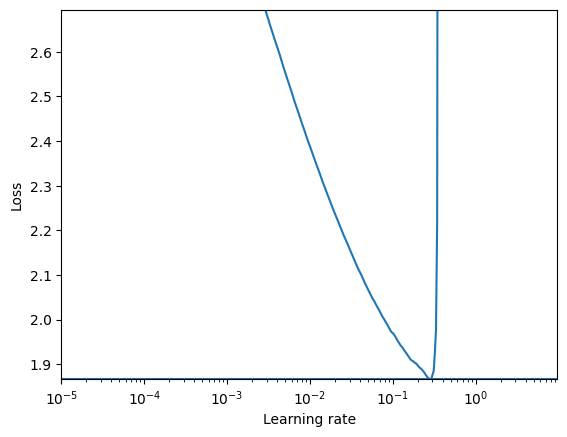

In [15]:
# Example to find optimum eta max
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
        
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(
        X, 
        y, 
        epochs=epochs, 
        batch_size=batch_size,
        callbacks=[exp_lr]
    )
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    
tf.random.set_seed(42)
np.random.seed(42)

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    tf.keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [16]:
' From the chapters provided notebook'

# Example implementing 1cycle
K = tf.keras.backend

class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None, last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
        
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(
    X_train_scaled,
    y_train,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data=(X_valid_scaled, y_valid),
    callbacks=[onecycle]
)

Epoch 1/25
430/430 [==============================] - 2s 4ms/step - loss: 0.6730 - accuracy: 0.7683 - val_loss: 0.4917 - val_accuracy: 0.8310
Epoch 2/25
430/430 [==============================] - 2s 4ms/step - loss: 0.4596 - accuracy: 0.8399 - val_loss: 0.4301 - val_accuracy: 0.8528
Epoch 3/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4129 - accuracy: 0.8549 - val_loss: 0.4150 - val_accuracy: 0.8620
Epoch 4/25
430/430 [==============================] - 2s 4ms/step - loss: 0.3839 - accuracy: 0.8644 - val_loss: 0.3898 - val_accuracy: 0.8672
Epoch 5/25
430/430 [==============================] - 2s 4ms/step - loss: 0.3637 - accuracy: 0.8709 - val_loss: 0.3739 - val_accuracy: 0.8714
Epoch 6/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3445 - accuracy: 0.8773 - val_loss: 0.3700 - val_accuracy: 0.8744
Epoch 7/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3309 - accuracy: 0.8819 - val_loss: 0.3628 - val_accuracy: 0.8754
Epoch 

### Avoid Overfitting Through Regularization

With thousands of parameters deep neural networks are prone to overfitting the training set. We need regularization. One of the best regularization techniques is early stopping. Moreover, Batch Normalization acts like a good regularizer too. Other popular techniques include $l_{1}$ and $l_{2}$ regularization, dropout, and max-norm regularization.

### $l_{1}$ and $l_{2}$ Regularization

You can use $l_{2}$ regularization to constrain a neural network's connection weights, and/or $l_{1}$ regularization if you want a sparse model (with many weights equal to 0). The l2() function returns a regularizer that will b e called at each step during training to compute the regularization loss. This is then added to the final loss. As you might expect, you can just use tf.keras.regularizers.l1() if you $l_{1}$ regularization; if you want both $l_{1}$ and $l_{2}$ regularization, use tf.keras.regularizers.l1_l2().

**Since you will typically want to apply the same regularizer to all layers in your network you may find yourself repeating the same arguments. This makes the code ugly and error-prone. To avoid this, you can try refactoring your code to use loops. Another option is to use Python's functools.partial() function, which lets you create a thin wrapper for any callable, with some default argument values, as shown below.**

In [17]:
# Example applying l2 regularization
layer = tf.keras.layers.Dense(
    100,
    activation='elu',
    kernel_initializer='he_normal',
    kernel_regularizer=tf.keras.regularizers.l2(0.01)
)

# Example using functools to refactor repetitive code
from functools import partial

RegularizeDense = partial(
    tf.keras.layers.Dense,
    activation='elu',
    kernel_initializer='he_normal',
    kernel_regularizer=tf.keras.regularizers.l2(0.01)
)

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    RegularizeDense(300),
    RegularizeDense(100),
    RegularizeDense(10, activation='softmax', kernel_initializer='glorot_uniform')
    
])

### Dropout

*Dropout* is one of the most popular regularization techniques for deep neural networks. Even state-of-the-art neural networks get a 1-2% accuracy boost simply by adding dropout. It is a fairly simple algorithm: at every training step, every neuron (including the input neurons, but always excluding the output neurons) has a probability *p* of being temporarily "dropped out", meaning it will be entirely ignored during this training step, but it may be active during the next step. **The hyperparameter *p* is called the *dropout rate*, and it is typically set between 10% and 50%: closer to 20-30% in recurrent neural nets, and closer to 40-50% in convolutional neural networks.** After training, neurons don't get dropped anymore.

Think of it like this: 

Would a company perform better if its employees were told to toss a coin every morning to decide whether or not to go to work? Well, who knows, perhaps it would! The company would be forced to adapt its organization; it could not rely on any single person to work the coffee machine or perform any other critical tasks, so this expertise would have to be spread across several people. Employees would have to learn to cooperate with many of their coworkers, not just a handful of them. This company would become much more resilient. It's unclear if whether this idea would actually work for companies, but it certainly does for neural networks. They end up being less sensitive to slight changes in the inputs. In the end, you get a more robust network that generalizes better.

Another way to understand the power of dropout is to realize that a unique neural network is generated at each training step. Once you have run 10,000 training steps, yo uhave essentially trained 10,000 different neural networks. The resulting neural network can be seen as an averaging ensemble of all these smaller networks. In general, you can usually apply dropout only to the neurons in the top 1-3 layers, excluding the output layer, of course.

There is one small but important technical detail: we need to multiply each input connection weight by the *keep probability* (1 - p) after training. Alternatively, we can divide each neuron's output by the keep probability during training. This is a consequence of the fact that during testing, a neuron that was not dropped out will be connected to more inputs than if all neurons were present. This artifically increases the input weight assigned to that neuron.

To implement dropout using Keras, you can use the keras.layers.Dropout layer. During training, it randomly drops some inputs (setting them to 0) and divides the remaining inputs by the keep probability. After training, it does nothing at all; it just passes the inputs to the next layer.

**Since dropout is only active during training, comparing the training loss and the validation loss can be misleading. In particular, a model may be overfitting the training set and yet have simliar training and validation losses. So make sure you evaluate the training loss without dropout (e.g., after training).**

**If you observe that the model is overfitting, you can increase the dropout rate. Conversely, you should try decreasing the dropout rate for large layers, and reduce it for small ones. Moreover, many state-of-the-art architectures only use dropout after the last hidden layer, so you may want to try this if full dropout is too strong.**

Dropout does tend to significantly slow down convergence, but it usually results in a much better model when tuned properly. So, it is generally well worth the extra time and effort.

If you want to regularize a self-normalizing network based on the SELU activation function, you should use *alpha dropout*: this is a variant of dropout that preserves the mean and standard deviation of its inputs.

Yarin Gal and Zoubin Ghaharamani published a paper in 2016 adding a few more good reasons to use dropout:
1. First, the paper established a profound connection between dropout networks and approximate Bayesian inference, giving dropout a solid mathematical justification.
2. Second, the authors introduced a powerful technique called *Monte Carlo Dropout*, which can boost the performance of any trained dropout model without having to retrain it or even modify it at all, provides a much better measure of the model's uncertainty, and is also amazingly simple to implement.

In [18]:
# Example implmenting dropout
model = tf.keras.models.Sequential([
    tf.keras.layers.Input([28, 28]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

### Monte Carlo (MC) Dropout

The full implementation is remarkable simple, as seen below, and boosts any dropout model without retraining it. In this example, we just make 100 predictions over the test set, setting training=True to ensure that the Dropout layer is active, and stack the predictions. Since dropout is active, all the predictions will be different. 

That all! Averaging over multiple predictions with dropout on gives us a Monte Carlo estimate that is generally more reliable than the result of a single prediction with dropout off. 

**The number of Monte Carlo samples you use (100 in this example) is a hyperparameter you can tweak. The higher it is, the more accurate the predictions and their uncertainty estimates will be. However, if you double it, inference time will also be doubled. Moreover, above a certain number of samples, you will notice little improvement. So your job is finding the right trade-off between latency and accuracy, depending on your application.**

In [19]:
# Implementing MC Dropout
y_probas = np.stack([model(X_test_scaled, training=True) for sample in range(100)])
y_proba = y_probas.mean(axis=0)

In [20]:
# Exploring MC Dropout results
np.round(model.predict(X_test_scaled[:1]), 2)

1/1 [==============================] - 0s 77ms/step


array([[0.56, 0.  , 0.02, 0.  , 0.11, 0.13, 0.09, 0.05, 0.01, 0.03]],
      dtype=float32)

In [21]:
np.round(y_probas[:10, :1], 2)

array([[[0.32, 0.  , 0.  , 0.  , 0.14, 0.08, 0.23, 0.19, 0.03, 0.  ]],

       [[0.68, 0.  , 0.02, 0.  , 0.07, 0.18, 0.02, 0.03, 0.  , 0.01]],

       [[0.23, 0.  , 0.11, 0.  , 0.41, 0.07, 0.15, 0.01, 0.  , 0.03]],

       [[0.07, 0.  , 0.07, 0.  , 0.22, 0.39, 0.02, 0.03, 0.01, 0.18]],

       [[0.25, 0.  , 0.  , 0.  , 0.08, 0.27, 0.1 , 0.2 , 0.08, 0.03]],

       [[0.63, 0.  , 0.02, 0.  , 0.2 , 0.  , 0.  , 0.13, 0.01, 0.  ]],

       [[0.39, 0.01, 0.01, 0.  , 0.27, 0.08, 0.16, 0.03, 0.03, 0.02]],

       [[0.62, 0.  , 0.  , 0.  , 0.13, 0.  , 0.02, 0.18, 0.04, 0.  ]],

       [[0.14, 0.  , 0.06, 0.  , 0.04, 0.48, 0.08, 0.09, 0.08, 0.03]],

       [[0.07, 0.  , 0.  , 0.  , 0.25, 0.09, 0.43, 0.1 , 0.06, 0.  ]]],
      dtype=float32)

In [22]:
np.round(model.predict(X_test_scaled[:1]), 2), np.round(y_proba[:1], 2)

1/1 [==============================] - 0s 20ms/step


(array([[0.56, 0.  , 0.02, 0.  , 0.11, 0.13, 0.09, 0.05, 0.01, 0.03]],
       dtype=float32),
 array([[0.35, 0.  , 0.02, 0.  , 0.14, 0.17, 0.14, 0.09, 0.03, 0.05]],
       dtype=float32))

In [23]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

''' 
Apparently there is quite a lot of variance in the probability estimates: if you were building a risk-senstive system (e.g. a medical or financial system),
you should probably treat such an uncertain prediction with extreme caution. You definitely would not treat it like a 99% confident prediction.
'''

' \nApparently there is quite a lot of variance in the probability estimates: if you were building a risk-senstive system (e.g. a medical or financial system),\nyou should probably treat such an uncertain prediction with extreme caution. You definitely would not treat it like a 99% confident prediction.\n'

**If your model contains other layers that behave in a special way during training (such as BatchNormalization layers), then you should not force training mode like we just did. Instead, you should replace the Dropout layers with the following MCDropout class.**

Here, we just subclass the Dropout layer and override the call() method to force its training argument to True. Similarly, you could define an MCAlpha Dropout class by subclassing AlphaDropout instead. If you are creating am odel from scratch, it's just a matter of using MCDropout rather than Dropout. But if you have a model that was already trained using Dropout, you need to create a new model that's identical to the existing model except that it replaces the Dropout layers with MCDropout, then copy the existing model's weights to your new model.

**In short, MC Dropout is a fantastic technique that boosts dropout models and provides better uncertainty estimates. And of course, since it is just regular dropout during trianing, it also acts like a regularizer.**

In [24]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

### Max-Norm Regularization

Another regularization technique that is popular for neural networks is called *max-norm regularization*: for each neuron, it constrains the weights **w** of the incoming connections succh that $||w||_{2}$ $\le$ r, where *r* is the max-norm hyperparameter and $||\cdot||_{2}$ is the $l_{2}$ norm.

**Reducing *r* increases the amount of regularization and helps reduce overfitting. Max-norm regularization can also help alleviate the unstable gradients problems if you aren't using Batch Normalization**.

To implement max-norm regulariation in Keras, set the kernel_constraint argument of each hidden layer to a max_norm() constraint with the appropriate max value, as shown below.

**The max_norm() function has an axis argument that defaults to 0. A Dense layer usually has weights of shape [number of inputs, numer of neurons], so using axis=0 means that the max-norm constraint will apply independently to each neuron's weight vector. If you want to use max-norm with convolutional layers, make sure to set the max_norm() constraint's axis argument appropriately (usually axis=[0, 1, 2])**

In [25]:
# Implementing max-norm regularization
tf.keras.layers.Dense(
    100,
    activation='elu',
    kernel_initializer='he_normal',
    kernel_constraint=tf.keras.constraints.max_norm(1.)
)

### Summary and Practical Guidelines

The configuration in the first DataFrame work fine in most cases, however do not consider these defaults as hard rules! The second is a good default for a simple stack of desne layers. Don't forget to normalize the input features! You should also try to reuse parts of a pretrained neural network if you can find one that solves a similar problem, or use unsupervised pretraining if you have a lot of unlabeled data, or use pretraining on an auxiliary task if you ahve a lot of labeled data for a similar task. 

While the previous guidelines should cover most cases, here are some exceptions:
1. If you need a sparse model, you can use $l_{1}$ regularization (and optionally zero out the tiny weights after training). If you need an even sparser model, you can use the TensorFlow Model Optimization Toolkit. This will break self-normalization, so you should use the default configuration in this case.
2. If you need a low-latency model (one that performs lightning-fast predictions), you may need to use fewer layers, fold the Batch Normalization layers in the previous layers, and possibly use a faster activation function such as leaky ReLU or just ReLU. Having a sparse model will also help. Finally, you may want to reduce the float precision from 32 bits to 16 or even 8 bits. Again, check out TF-MOT
3. If you are building a risk-sensitive application, or inference latency is not very important in your application, you can use MC Dropout to boost performance and get more reliable probability estimates, along with uncertainty estimates.

In [26]:
# Default DNN configuration
dnn_defaults = pd.DataFrame(
    columns=['Hyperparameter', 'Default Value'],
    data=np.array([
        ['Kernel initializer', 'He initialization'],
        ['Activation function', 'ELU'],
        ['Normalization', 'None if shallow; Batch Norm if deep'],
        ['Regularization', 'Early stopping (+ $l_{2}$ if needed)'],
        ['Optimizer', 'Momentum optimization (or RMSProp or Nadam)'],
        ['Learning rate cycle', '1cycle']
    ])
)

dnn_defaults

,Hyperparameter,Default Value
0,Kernel initializer,He initialization
1,Activation function,ELU
2,Normalization,None if shallow; Batch Norm if deep
3,Regularization,Early stopping (+ $l_{2}$ if needed)
4,Optimizer,Momentum optimization (or RMSProp or Nadam)
5,Learning rate cycle,1cycle


In [27]:
self_norm_defaults = pd.DataFrame(
    columns=['Hyperparameter', 'Default Value'],
    data=np.array([
        ['Kernel initializer', 'LeCun initialization'],
        ['Activation function', 'SELU'],
        ['Normalization', 'None'],
        ['Regularization', 'Alpha dropout if needed)'],
        ['Optimizer', 'Momentum optimization (or RMSProp or Nadam)'],
        ['Learning rate cycle', '1cycle']
    ])
)

self_norm_defaults

,Hyperparameter,Default Value
0,Kernel initializer,LeCun initialization
1,Activation function,SELU
2,Normalization,None
3,Regularization,Alpha dropout if needed)
4,Optimizer,Momentum optimization (or RMSProp or Nadam)
5,Learning rate cycle,1cycle


# Exercises

**1. Is it OK to initialize all the weights to the same value as long as that value is selected randomly using He initialization?**

*My answer*

Regardless of how the weights are assigned, they should never be assigned to the same value. If they are all the same value it makes backpropagation nearly impossible to converge.

*Book answer*

No, all weights should be sampled independently; they should not all have the same initial value. One important goal of sampling weights randomly is to break symmetry: if all the weights have the same initial value, even if that value is not zero, then symmetry is not broken (i.e., all neurons in a given layer are equivalent), and backpropagation will be unable to break it. Concretely, this means that all the neurons in any given layer will always have the same weights. It's like having just one neuron per layer, and much slower. It is virtually impossible for such a configuration to converge to a good solution.

**2. Is it OK to initialize the bias terms to 0?**

*My answer*

Yes, biases can be initialized at 0

*Book answer*

It is perfectly fine to initialize the bias terms to zero. Some people like to initialize them just like weights, and that's ok too; it does not make much difference.

**3. Name three advantages of the SELU activation function over ReLU**

*My answer*

1. SELU self-normalizes
2. It can process negative values
3. Because it is a smooth function it can speed up gradient desecent

*Book answer*

A few advantages of the SELU function over the ReLU function are:

1. It can take on negative values, so the average output of the neurons in any given layer is typically closer to zero than when using the ReLU activation function (which never outputs negative values). This helps alleviate the vanishing gradients problem.
2. It always has a nonzero derivative, which avoids the dying units issue that can affect ReLU units.
3. When the conditions are right (i.e., if the model is sequential, and the weights are initialized using LeCun initialization, and the inputs are standardized, and there's no incompatible layer or regularization, such as dropout or $l_{1}$ regularization), then the SELU activation function ensures the model is self-normalized, which solves the exploding/vanshing gradients problem.

**4. In which cases would you want to use each of the following activation functions: SELU, leaky ReLU (and its variants), ReLU, tanh, logistic, and softmax?**

*My answer*

SELU: You have a sequential model of Dense layers. Less valuable for CNNs, RNNs and Wide & Deep models, but can still provide value.
<br>
Leaky ReLU: Speed and when you want to output negative values
<br>
ReLU: Speed and simplicity are valued to a greater extent than maximizing performance.
<br>
Tanh: Rarely used in DNNS, used more in RNNs. Useful if you need outputs between -1 and 1
<br>
Logistic: Rarely used in DNNs, used in autoencoders. Useful in output layers for binary classification.
<br>
Softmax: Almost solely used in output layers for multiclass classification probabilities.

*Book answer*

SELU: A good base case.
<br>
Leaky ReLU: When speed is the most important.
<br>
ReLU: For simplicity or to take advantage of software/hardware optimization/acceleration
<br>
Tanh: Rarely used in DNNs these days. Still used in RNNs. Useful when the outputs need to be between -1 and 1
<br>
Logistic: Used more in autoencoders. For DNNs, logistic activation functions are most often used in the output layers for binary classification probabilities.
<br>
Softmax: Rarely, if ever, used in hidden layers. Used in outout layers for multiclass classification probabilities.

**5. What may happen if you set the momentum hyperparameter too close to 1 (e.g. 0.999999) when using an SGD optimizer?**

*My answer*

If the momentum is 1 or close to one it will oscillate at the local or absolute minima for a long time before converging.

*Book answer*

If you set the momentum hyperparameter too close to 1 when using an SGD optimizer, then the algorithm will likely pick up a lot of speed, hopefully moving roughly toward the global minimum, but its momentum will carry it right past the minimum. Then it will slow down and come back, accelerate again, overshoot again, and so son. It may oscillate this way many times before converging, so overall it will take much longer to converge than with a smaller momentum value.

**6. Name three ways you can produce a sparse model.**

*My answer*

1. Manually zero-out small weights after training is done.
2. Apply $l_{1}$ regularization
3. Use the TensorFlow Model Optimization Toolkit

*Book answer*

1. Manually zero-out small weights after training is done.
2. Apply $l_{1}$ regularization
3. Use the TensorFlow Model Optimization Toolkit

**7. Does dropout slow down training? Does it slow down inference (i.e. making predictions on new instances)? What about MC Dropout?**

*My answer*

Yes, dropout slows down training. Since the dropout layer are inactivated after training is finished inference speed is not impacted. For MC Dropout, however, the dropout layers are still active after training is complete, so inference time scales linearly with the amount of samples.

*Book answer*

Yes, dropout does slow down training, in general roughly by a factor of two. However, it has no impact on inference speed since it is only turned on during training. MC Dropout is exactly like dropout during training, but it is still active during inference, so each inference is slowed down slightly. More importantly, when using MC Dropout you generally want to run inference 10 times or more to get better predictions. This means that making predictions is slowed down by a factor of 10 or more.

**8. Practice training a deep neural network on the CIFAR10 image dataset:**
1. Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but its the point of this exercise). Use He initialization and the ELU activation function.
2. Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with keras.datasets.cifar10.load_data(). The dataset is composed of 60,000 32x32 pixel color images (50k for training, 10k for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. **Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.**
3. Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?
4. Try replacing Batch Normalization with SELU, and make the necessary adjustments to ensure the network self-normalizes (i.e. standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.)
5. Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.
6. Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.

In [28]:
from keras.datasets import cifar10
from sklearn.preprocessing import MinMaxScaler

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train_scaled, x_test_scaled = x_train - np.mean(x_train) / np.std(x_train), x_test - np.mean(x_train) / np.std(x_train)
x_train_scaled, x_val_scaled = x_train_scaled[:40000], x_train_scaled[40000:]
y_train, y_val = y_train[:40000], y_train[40000:]

In [29]:
x_train.shape, y_train.shape, x_test.shape

((50000, 32, 32, 3), (40000, 1), (10000, 32, 32, 3))

In [30]:
x_train[:40000].shape

(40000, 32, 32, 3)

In [31]:
class OptimalLearningRate(tf.keras.callbacks.Callback):
    ' During the first epoch change the learning rate for each batch then set the model learning rate to the rate that provides the lowest loss'
    
    def __init__(self, instances: int, batch_size: int, min_rate: float = 1e-6, max_rate: float = 1e-1):
        super().__init__()
        self.learning_rate_ = min_rate
        self.losses_ = {}
        self.optimal_learning_rate_ = 1e-3
        self.found_optimal_learning_rate_ = False
        self.weights_ = None
        self.instances_ = instances
        self.batch_size_ = batch_size
        self.min_rate_ = min_rate
        self.learning_rate_growth_rate_ = np.exp(np.log(max_rate / min_rate) / math.ceil(self.instances_ / self.batch_size_))
        self.backend_ = tf.keras.backend


    def on_train_begin(self, logs=None):
        ' Store initial model weights at the beginning of training.'
        self.weights_ = self.model.get_weights()
        return

    def on_epoch_end(self, epoch, logs=None):
        ' After the end of the first epoch, set the model learning rate to the optimal rate. Restore original weights.'

        if self.found_optimal_learning_rate_:
            return
        else:
            self.model.set_weights(self.weights_)
            self.backend_.set_value(self.model.optimizer.learning_rate, min(self.losses_, key=self.losses_.get))
            self.learning_rate_ = self.min_rate_
            self.found_optimal_learning_rate_ = True
        return

    def on_batch_end(self, batch, logs):  
        ' If the optimal learning rate hasnt been found, adjust the learning rate at each epoch until it is found'
        
        if self.found_optimal_learning_rate_: 
            return
        else:
            self.losses_[self.learning_rate_] = logs['loss']
            self.learning_rate_ = self.learning_rate_ * self.learning_rate_growth_rate_
            self.backend_.set_value(self.model.optimizer.learning_rate, self.learning_rate_)
            return

    def plot_learning_rate_results(self):
        ' Plots the learning rates - loss curve'

        optimum_rate = min(self.losses_, key=self.losses_.get)
        print(f'Optimum learning rate: {optimum_rate:.2E}')
        plt.plot(self.losses_.keys(), self.losses_.values())
        plt.gca().set_xscale('log')
        plt.hlines(min(self.losses_.values()), min(self.losses_.keys()), max(self.losses_.keys()))
        plt.axis([min(self.losses_.keys()), max(self.losses_.keys()), min(self.losses_.values()), (max(self.losses_.values()) + min(self.losses_.values())) / 2])
        plt.axvline(x=optimum_rate, c='red')
        plt.xlabel("Learning rate")
        plt.ylabel("Loss")
        return

Epoch 1/50
157/157 [==============================] - 8s 18ms/step - loss: 10.8612 - accuracy: 0.1629 - val_loss: 2.2072 - val_accuracy: 0.1999
Epoch 2/50
157/157 [==============================] - 2s 15ms/step - loss: 2.0789 - accuracy: 0.2413 - val_loss: 2.0506 - val_accuracy: 0.2428
Epoch 3/50
157/157 [==============================] - 2s 14ms/step - loss: 1.9760 - accuracy: 0.2771 - val_loss: 1.9638 - val_accuracy: 0.2924
Epoch 4/50
157/157 [==============================] - 2s 14ms/step - loss: 1.9026 - accuracy: 0.3061 - val_loss: 1.9245 - val_accuracy: 0.2981
Epoch 5/50
157/157 [==============================] - 2s 15ms/step - loss: 1.8513 - accuracy: 0.3270 - val_loss: 1.8878 - val_accuracy: 0.3222
Epoch 6/50
157/157 [==============================] - 2s 15ms/step - loss: 1.8081 - accuracy: 0.3410 - val_loss: 1.8490 - val_accuracy: 0.3163
Epoch 7/50
157/157 [==============================] - 2s 15ms/step - loss: 1.7715 - accuracy: 0.3570 - val_loss: 1.8072 - val_accuracy: 0.350

<Axes: >

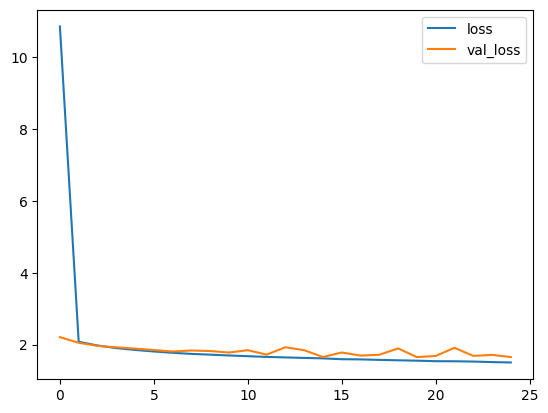

In [37]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[32, 32, 3]),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Nadam(learning_rate=5e-4),
    metrics=['accuracy']
)

batch_size = 256
epochs = 50

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    # OptimalLearningRate(instances=x_train_scaled.shape[0], batch_size=128),
    # OneCycleScheduler(math.ceil(len(x_train_scaled) / batch_size) * epochs, max_rate=5e-1)
    # tf.keras.callbacks.ModelCheckpoint(
    #     filepath='./model_checkpoints/{epoch:02d}-{val_loss:.2f}.tf',
    #     monitor='val_loss',
    #     save_best_only=True
    # ),
]

history=model.fit(
    x=x_train_scaled,
    y=y_train,
    batch_size=batch_size,
    validation_data=(x_val_scaled, y_val),
    callbacks=my_callbacks,
    epochs=epochs
)

print(model.evaluate(x_val_scaled, y_val))
model_1_hist = pd.DataFrame.from_dict(history.history)
model_1_hist.index.name = 'Epoch'
model_1_hist = model_1_hist.reset_index()
model_1_hist.loc[:, ['loss', 'val_loss']].plot()

Epoch 1/50
157/157 [==============================] - 16s 30ms/step - loss: 2.0045 - accuracy: 0.2887 - val_loss: 2.2514 - val_accuracy: 0.2745
Epoch 2/50
157/157 [==============================] - 4s 23ms/step - loss: 1.6770 - accuracy: 0.3985 - val_loss: 2.0719 - val_accuracy: 0.3148
Epoch 3/50
157/157 [==============================] - 3s 22ms/step - loss: 1.5629 - accuracy: 0.4418 - val_loss: 1.7469 - val_accuracy: 0.3898
Epoch 4/50
157/157 [==============================] - 3s 22ms/step - loss: 1.4794 - accuracy: 0.4729 - val_loss: 1.8305 - val_accuracy: 0.3619
Epoch 5/50
157/157 [==============================] - 3s 21ms/step - loss: 1.4232 - accuracy: 0.4956 - val_loss: 1.6327 - val_accuracy: 0.4298
Epoch 6/50
157/157 [==============================] - 3s 22ms/step - loss: 1.3730 - accuracy: 0.5157 - val_loss: 1.7095 - val_accuracy: 0.4200
Epoch 7/50
157/157 [==============================] - 3s 21ms/step - loss: 1.3339 - accuracy: 0.5276 - val_loss: 1.6109 - val_accuracy: 0.443

<Axes: >

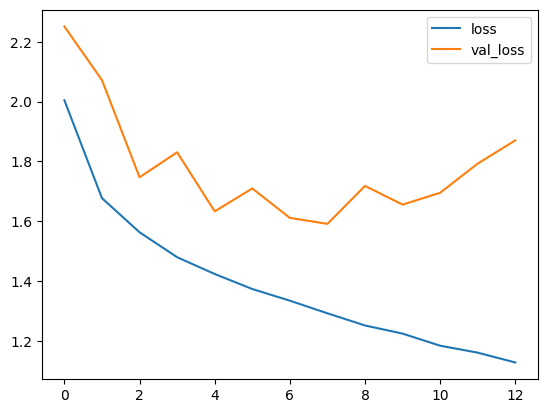

In [38]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[32, 32, 3]),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Nadam(learning_rate=5e-4),
    metrics=['accuracy']
)

batch_size = 256
epochs = 50

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    # OptimalLearningRate(instances=x_train_scaled.shape[0], batch_size=128),
    # OneCycleScheduler(math.ceil(len(x_train_scaled) / batch_size) * epochs, max_rate=5e-1)
    # tf.keras.callbacks.ModelCheckpoint(
    #     filepath='./model_checkpoints/{epoch:02d}-{val_loss:.2f}.tf',
    #     monitor='val_loss',
    #     save_best_only=True
    # ),
]

history=model.fit(
    x=x_train_scaled,
    y=y_train,
    batch_size=batch_size,
    validation_data=(x_val_scaled, y_val),
    callbacks=my_callbacks,
    epochs=epochs
)

print(model.evaluate(x_val_scaled, y_val))
model_1_hist = pd.DataFrame.from_dict(history.history)
model_1_hist.index.name = 'Epoch'
model_1_hist = model_1_hist.reset_index()
model_1_hist.loc[:, ['loss', 'val_loss']].plot()

Epoch 1/50
625/625 [==============================] - 21s 14ms/step - loss: 1.8981 - accuracy: 0.3162 - val_loss: 1.9600 - val_accuracy: 0.3426
Epoch 2/50
625/625 [==============================] - 8s 13ms/step - loss: 1.6926 - accuracy: 0.3958 - val_loss: 1.8062 - val_accuracy: 0.4141
Epoch 3/50
625/625 [==============================] - 8s 13ms/step - loss: 1.6134 - accuracy: 0.4284 - val_loss: 1.7114 - val_accuracy: 0.4331
Epoch 4/50
625/625 [==============================] - 8s 13ms/step - loss: 1.5595 - accuracy: 0.4463 - val_loss: 1.6348 - val_accuracy: 0.4499
Epoch 5/50
625/625 [==============================] - 8s 13ms/step - loss: 1.5118 - accuracy: 0.4675 - val_loss: 1.6445 - val_accuracy: 0.4469
Epoch 6/50
625/625 [==============================] - 8s 13ms/step - loss: 1.4755 - accuracy: 0.4838 - val_loss: 1.6364 - val_accuracy: 0.4557
Epoch 7/50
625/625 [==============================] - 8s 13ms/step - loss: 1.4363 - accuracy: 0.4993 - val_loss: 1.7816 - val_accuracy: 0.440

<Axes: >

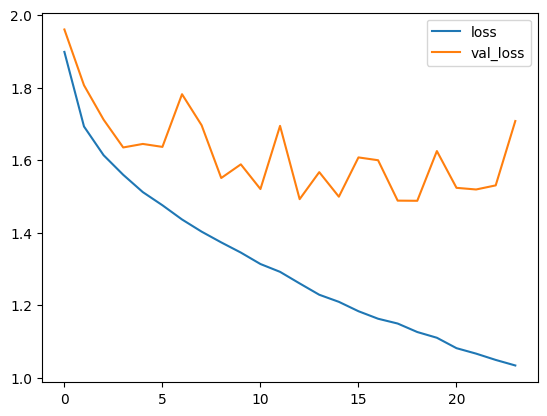

In [39]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[32, 32, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Nadam(learning_rate=5e-3),
    metrics=['accuracy']
)

batch_size = 256
epochs = 50

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    # OptimalLearningRate(instances=x_train_scaled.shape[0], batch_size=128),
    # OneCycleScheduler(math.ceil(len(x_train_scaled) / batch_size) * epochs, max_rate=5e-1)
    # tf.keras.callbacks.ModelCheckpoint(
    #     filepath='./model_checkpoints/{epoch:02d}-{val_loss:.2f}.tf',
    #     monitor='val_loss',
    #     save_best_only=True
    # ),
]

history=model.fit(
    x=x_train_scaled,
    y=y_train,
    batch_size=batch_size,
    validation_data=(x_val_scaled, y_val),
    callbacks=my_callbacks,
    epochs=epochs
)

print(model.evaluate(x_val_scaled, y_val))
model_1_hist = pd.DataFrame.from_dict(history.history)
model_1_hist.index.name = 'Epoch'
model_1_hist = model_1_hist.reset_index()
model_1_hist.loc[:, ['loss', 'val_loss']].plot()

Epoch 1/50
157/157 [==============================] - 8s 18ms/step - loss: 2.3813 - accuracy: 0.1616 - val_loss: 2.1499 - val_accuracy: 0.2111
Epoch 2/50
157/157 [==============================] - 2s 16ms/step - loss: 2.0727 - accuracy: 0.2378 - val_loss: 2.0401 - val_accuracy: 0.2569
Epoch 3/50
157/157 [==============================] - 3s 16ms/step - loss: 1.9811 - accuracy: 0.2790 - val_loss: 1.9712 - val_accuracy: 0.2839
Epoch 4/50
157/157 [==============================] - 3s 16ms/step - loss: 1.9203 - accuracy: 0.3022 - val_loss: 1.9287 - val_accuracy: 0.2999
Epoch 5/50
157/157 [==============================] - 2s 16ms/step - loss: 1.8785 - accuracy: 0.3179 - val_loss: 1.8977 - val_accuracy: 0.3160
Epoch 6/50
157/157 [==============================] - 3s 17ms/step - loss: 1.8462 - accuracy: 0.3310 - val_loss: 1.8745 - val_accuracy: 0.3181
Epoch 7/50
157/157 [==============================] - 2s 16ms/step - loss: 1.8187 - accuracy: 0.3412 - val_loss: 1.8517 - val_accuracy: 0.3332

<Axes: >

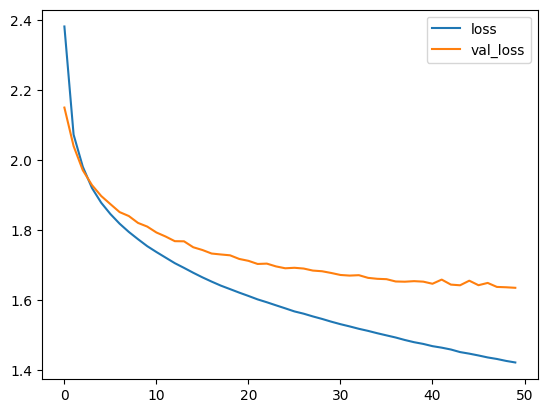

In [40]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[32, 32, 3]),
    tf.keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    tf.keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    tf.keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    tf.keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    tf.keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    tf.keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    tf.keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    tf.keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    tf.keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    tf.keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    tf.keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    tf.keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    tf.keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    tf.keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    tf.keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    tf.keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    tf.keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    tf.keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    tf.keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    tf.keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-5),
    metrics=['accuracy']
)

batch_size = 256
epochs = 50

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    # OptimalLearningRate(instances=x_train_scaled.shape[0], batch_size=128),
    # OneCycleScheduler(math.ceil(len(x_train_scaled) / batch_size) * epochs, max_rate=5e-1)
    # tf.keras.callbacks.ModelCheckpoint(
    #     filepath='./model_checkpoints/{epoch:02d}-{val_loss:.2f}.tf',
    #     monitor='val_loss',
    #     save_best_only=True
    # ),
]

history=model.fit(
    x=x_train_scaled,
    y=y_train,
    batch_size=batch_size,
    validation_data=(x_val_scaled, y_val),
    callbacks=my_callbacks,
    epochs=epochs
)

print(model.evaluate(x_val_scaled, y_val))
model_1_hist = pd.DataFrame.from_dict(history.history)
model_1_hist.index.name = 'Epoch'
model_1_hist = model_1_hist.reset_index()
model_1_hist.loc[:, ['loss', 'val_loss']].plot()

Epoch 1/200
313/313 [==============================] - 11s 18ms/step - loss: 2.5169 - accuracy: 0.1512 - val_loss: 2.0893 - val_accuracy: 0.2409
Epoch 2/200
313/313 [==============================] - 4s 14ms/step - loss: 2.2310 - accuracy: 0.2084 - val_loss: 1.9787 - val_accuracy: 0.2861
Epoch 3/200
313/313 [==============================] - 4s 13ms/step - loss: 2.1145 - accuracy: 0.2415 - val_loss: 1.9231 - val_accuracy: 0.3104
Epoch 4/200
313/313 [==============================] - 4s 14ms/step - loss: 2.0319 - accuracy: 0.2657 - val_loss: 1.8804 - val_accuracy: 0.3257
Epoch 5/200
313/313 [==============================] - 4s 13ms/step - loss: 1.9694 - accuracy: 0.2907 - val_loss: 1.8673 - val_accuracy: 0.3386
Epoch 6/200
313/313 [==============================] - 4s 14ms/step - loss: 1.9306 - accuracy: 0.3013 - val_loss: 1.8199 - val_accuracy: 0.3466
Epoch 7/200
313/313 [==============================] - 4s 13ms/step - loss: 1.8835 - accuracy: 0.3179 - val_loss: 1.8051 - val_accuracy

<Axes: >

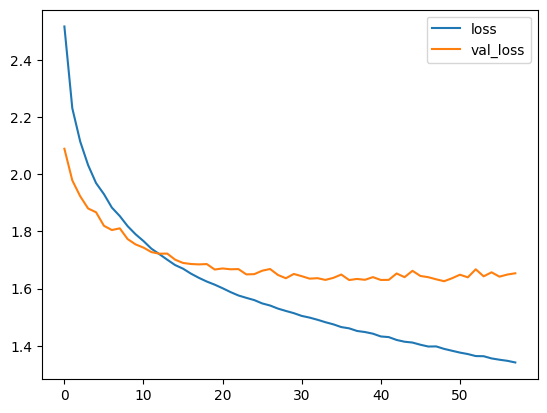

In [61]:
total_layers = 20

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for i in range(total_layers):

    if not i % 7:
        # model.add(tf.keras.layers.AlphaDropout(rate=0.1))
        model.add(tf.keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'))

    else:
        model.add(tf.keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'))

    if i == max(range(total_layers)):
        model.add(tf.keras.layers.AlphaDropout(rate=0.15))
        model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-5),
    metrics=['accuracy']
)

batch_size = 128
epochs = 200

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
    # tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    # OptimalLearningRate(instances=x_train_scaled.shape[0], batch_size=128),
    # OneCycleScheduler(math.ceil(len(x_train_scaled) / batch_size) * epochs, max_rate=5e-1)
    # tf.keras.callbacks.ModelCheckpoint(
    #     filepath='./model_checkpoints/{epoch:02d}-{val_loss:.2f}.tf',
    #     monitor='val_loss',
    #     save_best_only=True
    # ),
]

history=model.fit(
    x=x_train_scaled,
    y=y_train,
    batch_size=batch_size,
    validation_data=(x_val_scaled, y_val),
    callbacks=my_callbacks,
    epochs=epochs
)

print(model.evaluate(x_val_scaled, y_val))
model_1_hist = pd.DataFrame.from_dict(history.history)
model_1_hist.index.name = 'Epoch'
model_1_hist = model_1_hist.reset_index()
model_1_hist.loc[:, ['loss', 'val_loss']].plot()

In [ ]:
class MCAlphaDropout(tf.keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

mc_model = tf.keras.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, tf.keras.layers.AlphaDropout) else layer for layer in model.layers
])

y_probas = np.stack([mc_model.predict(x_val_scaled, verbose=0) for sample in range(150)])
y_proba = y_probas.mean(axis=0)
mc_model_predictions = np.argmax(y_proba, axis=1)
mc_accuracy = np.mean(mc_model_predictions == y_val[:, 0])
model_accuracy = round(model.evaluate(x_val_scaled, y_val)[1], 4)
print (f'MC Dropout model is more acccurate: {mc_accuracy > model_accuracy} | MC Dropout Accuracy: {mc_accuracy}, Model Accuracy: {model_accuracy}')